In [1]:
from pathlib import Path

import numba as nb
import numpy as np
import scipy.stats as stats

from natsort import natsorted

import matplotlib.pyplot as plt


#plt.style.use("mike")
#import warnings
#warnings.simplefilter("ignore")
#warnings.filterwarnings('ignore')


import astropy.units as u

import cmasher as cmr

green = "#33FF86"
purple = "#CE33FF"

%matplotlib widget
from cosmogrb.universe.survey import Survey

import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from zusammen.stan_models.stan_model import get_model
from zusammen import AnalysisBuilder, DataSet
from zusammen.spectral_plot import display_posterior_model_counts

from threeML import update_logging_level

import arviz as av


update_logging_level("FATAL")


from astromodels import Band_Calderone, PointSource, Model


from threeML import JointLikelihood, DataList, display_spectrum_model_counts

from astromodels import Cutoff_powerlaw

import popsynth as ps

16:50:53 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=802290;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=346770;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py#50\50]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=24546;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=184114;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/functions.py#71\71]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=671636;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=31736;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

16:50:54 INFO      Starting 3ML!                                                                     ]8;id=451975;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=634974;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#31\31]8;;\

         WARNING   no display variable set. using backend for graphics without display (agg)         ]8;id=265853;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=309298;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=255210;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=64447;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=22631;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=329795;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=662613;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=789892;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

16:50:54 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=647329;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=420918;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#79\79]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=836888;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=227327;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#129\129]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=146525;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=828491;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#129\129]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=986372;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=239344;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=104315;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=997191;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#341\341]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=943975;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=845148;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#341\341]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=348968;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=684015;file:///opt/homebrew/Caskroom/miniconda/base/envs/bachelor-3.8/lib/python3.8/site-packages/threeML/__init__.py#341\341]8;;\
                  performances in 3ML                                                                              

Import the survey and process the GRBs

In [ ]:
survey = Survey.from_file('data/survey.h5')
ab = AnalysisBuilder(survey, use_bb=True)

In [ ]:
ab.write_yaml("test_proc.yml")

In [2]:
ds = DataSet.from_yaml("test_proc.yml")

In [ ]:
ds.to_hdf5_file("sgrb.h5")

In [ ]:
ds.to_hdf5_file("sgrb.h5", sig_threshold=40)

In [ ]:
ds = DataSet.from_hdf5_file('sgrb.h5')

In [ ]:
ds.to_stan_dict()

In [ ]:
%matplotlib widget
i,j = 1,2
plt.plot(ds.to_stan_dict()["response"][i,j].T @ ds.to_stan_dict()['observed_counts'][i,j])

Make Stan model

In [3]:
m = get_model("cpl_simple_chunked_gc")

In [4]:
m.clean_model()

In [5]:
m.build_model(opt_exp=True)

In [6]:
data = ds.to_stan_dict()

n_threads = 2
n_chains = 2

fit = m.model.sample(
    data=data,
    parallel_chains=n_chains,
    chains=n_chains,
    inits= {
        'alpha': -1 * np.ones(data['N_intervals']),
        'log_ec': 2 * np.ones(data['N_intervals']),

        #'log_energy_flux': -7 * np.ones(data['N_intervals']),
        #'log_energy_flux_mu_raw': 0.00001,

        #'gamma_sig_meta': .00001,
        #'log_Nrest_sig_meta': .00001,
        #'gamma_mu_meta': 1,
        #'log_Nrest_mu_meta': 52,
        'gamma': np.ones(data['N_grbs']),
        'log_Nrest': 52 * np.ones(data['N_grbs'])
    },
    threads_per_chain=n_threads,
    seed=1234,
    iter_warmup=1000,
    iter_sampling=500,
    max_treedepth=12,
    adapt_delta=0.9,
    show_progress=True,
    #show_console=True
)

16:51:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

17:14:22 - cmdstanpy - INFO - CmdStan done processing.
17:14:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: integrate: error estimate of integral 8.72041e-74 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of integral 3.17342e-05 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of integral 1.34035e-05 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Documents/zusammen/zusammen/stan_models/cpl_simple_chunked_gc.stan', line 151, column 4 to column 105)
	Exception: integrate: error estimate of integral 2.94463e-05 exceeds the given relative tolerance times norm of integral (in '/Users/chrobin/Doc

In [7]:
fit

CmdStanMCMC: model=cpl_simple_chunked_gc chains=2['method=sample', 'num_samples=500', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=12', 'adapt', 'engaged=1', 'delta=0.9']
 csv_files:
	/var/folders/jh/4tg_3v1s0_j8p64dw1txwqzr0000gn/T/tmpxbk7kikb/cpl_simple_chunked_gchmm_fiug/cpl_simple_chunked_gc-20220912165102_1.csv
	/var/folders/jh/4tg_3v1s0_j8p64dw1txwqzr0000gn/T/tmpxbk7kikb/cpl_simple_chunked_gchmm_fiug/cpl_simple_chunked_gc-20220912165102_2.csv
 output_files:
	/var/folders/jh/4tg_3v1s0_j8p64dw1txwqzr0000gn/T/tmpxbk7kikb/cpl_simple_chunked_gchmm_fiug/cpl_simple_chunked_gc-20220912165102-stdout.txt

In [8]:
fit.diagnose()

"Processing csv files: /var/folders/jh/4tg_3v1s0_j8p64dw1txwqzr0000gn/T/tmpxbk7kikb/cpl_simple_chunked_gchmm_fiug/cpl_simple_chunked_gc-20220912165102_1.csv, /var/folders/jh/4tg_3v1s0_j8p64dw1txwqzr0000gn/T/tmpxbk7kikb/cpl_simple_chunked_gchmm_fiug/cpl_simple_chunked_gc-20220912165102_2.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n82 of 1000 (8.20%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete.\n"

Import Stan results into arviz

In [9]:
res = av.from_cmdstanpy(fit)

In [11]:
res.to_netcdf("inference_data/testing_unconstrained_gc_hierarchical.nc")

'inference_data/testing_unconstrained_gc_hierarchical.nc'

In [ ]:
res = av.from_netcdf("inference_data/testing_unconstrained_gc.nc")

In [ ]:
res.sample_stats

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'log_ec'}>,
        <AxesSubplot:title={'center':'log_ec'}>],
       [<AxesSubplot:title={'center':'log_Nrest'}>,
        <AxesSubplot:title={'center':'log_Nrest'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'gamma_mu_meta'}>,
        <AxesSubplot:title={'center':'gamma_mu_meta'}>],
       [<AxesSubplot:title={'center':'log_Nrest_mu_meta'}>,
        <AxesSubplot:title={'center':'log_Nrest_mu_meta'}>],
       [<AxesSubplot:title={'center':'gamma_sig_meta'}>,
        <AxesSubplot:title={'center':'gamma_sig_meta'}>],
       [<AxesSubplot:title={'center':'log_Nrest_sig_meta'}>,
        <AxesSubplot:title={'center':'log_Nrest_sig_meta'}>],
       [<AxesSubplot:title={'center':'ec'}>,
        <AxesSubplot:title={'center':'ec'}>],
       [<AxesSubplot:title={'center':'l

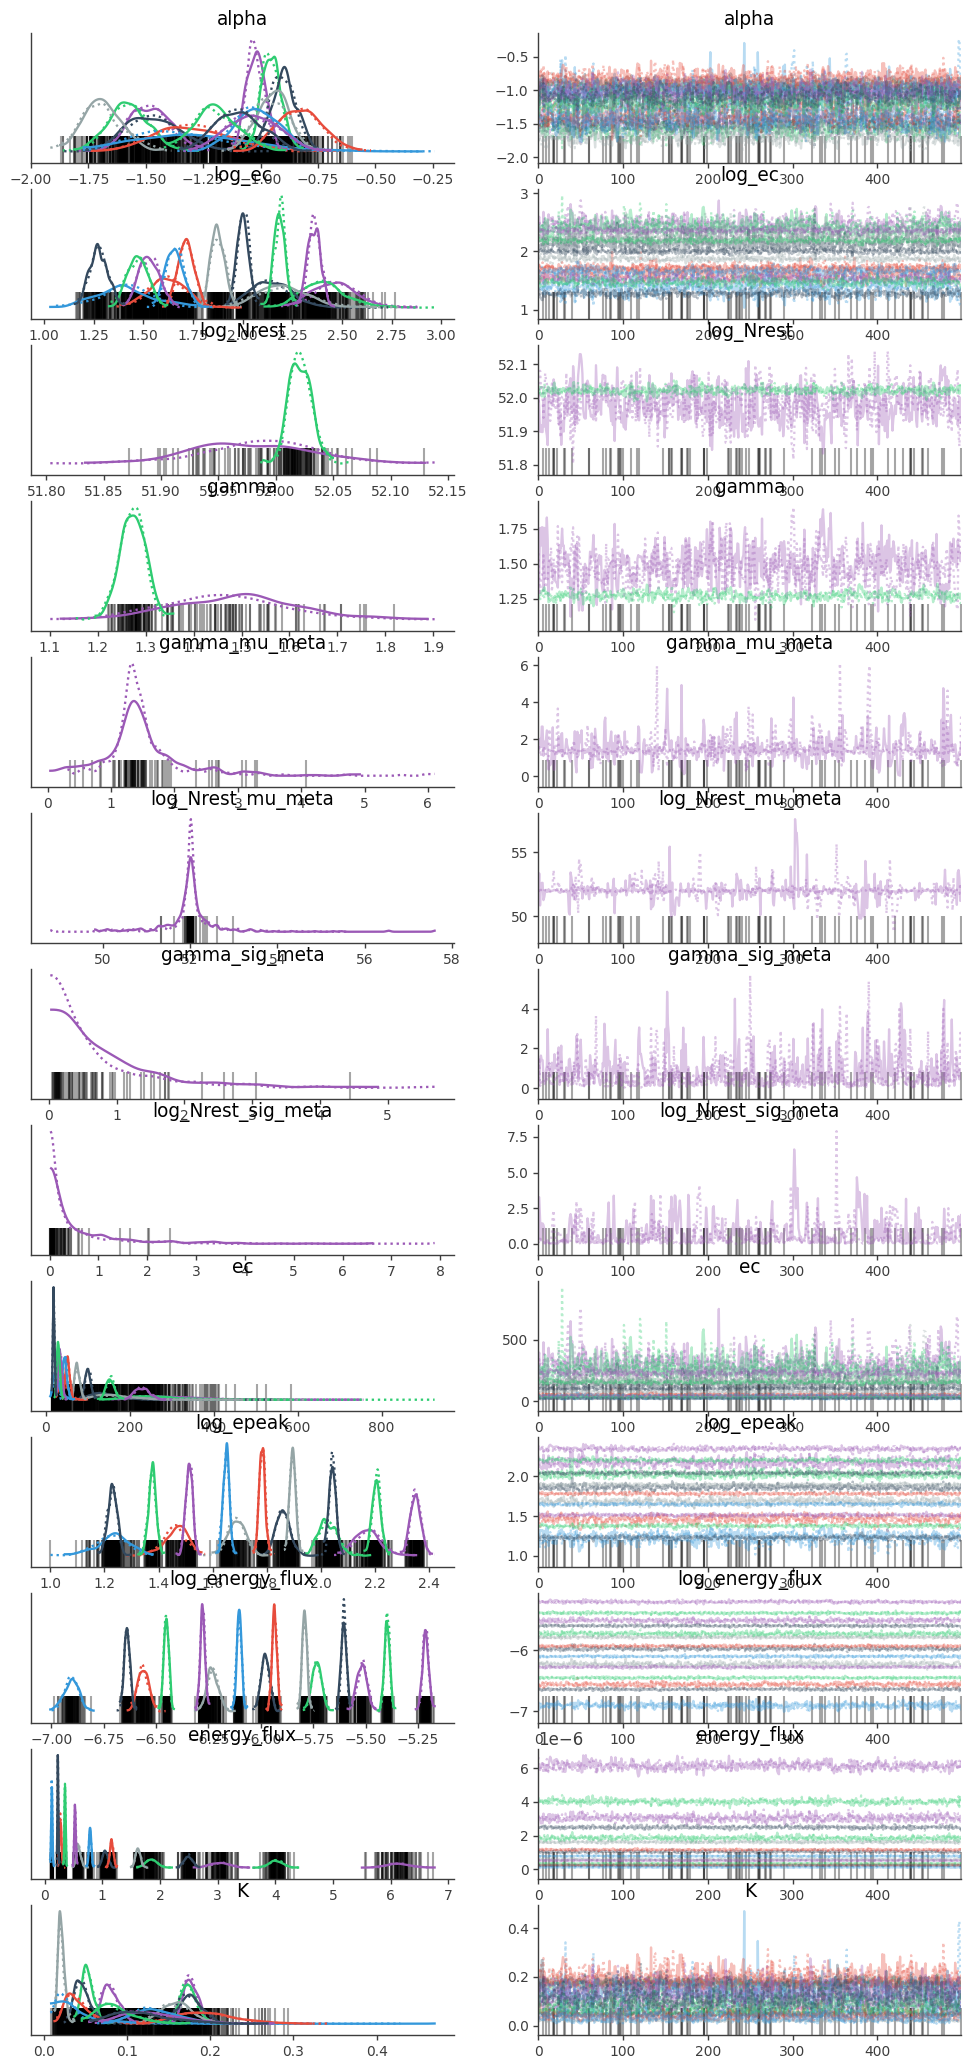

In [10]:
%matplotlib widget
av.plot_trace(res)

In [ ]:
%matplotlib widget
av.plot_pair(res, divergences=True)

Load parameters  

In [ ]:
id = 0


alpha = res.posterior.alpha.stack(sample=("chain", "draw")).values[id]

log_ec = res.posterior.log_ec.stack(sample=("chain", "draw")).values[id]

K  = res.posterior.K.stack(sample=("chain", "draw")).values[id]

log_epeak = res.posterior.log_epeak.stack(sample=("chain", "draw")).values[id]

energy_flux = res.posterior.energy_flux.stack(sample=("chain", "draw")).values[id]

gamma = res.posterior.gamma.stack(sample=("chain", "draw")).values[id]

log_Nrest = res.posterior.log_Nrest.stack(sample=("chain", "draw")).values[id]


div = res.sample_stats.diverging.stack(sample=("chain", "draw")).values

samples = np.vstack((K, alpha, 10.**log_ec))


dl = ds.get_data_list_of_interval(id)

In [ ]:
div.sum()

In [ ]:
bc = Cutoff_powerlaw(piv=100)

bc.index.bounds = (None, None)
bc.K.bounds = (None, None)
bc.xc.bounds = (None, None)

model = Model(PointSource("ps",0,0, spectral_shape=bc))

In [ ]:
%matplotlib widget
#fig, ax = plt.subplots()

plt.scatter(log_ec, alpha, alpha=0.1)

In [ ]:
fig, ax = plt.subplots()

ax.scatter(K, alpha, alpha=0.1)

In [ ]:
display_posterior_model_counts(
    dl[1], model, samples.T[::20], min_rate=1e-99, shade=False
)

In [ ]:
cpl = Cutoff_powerlaw(piv=100,K=1e-1,xc=200)


dl = ds.get_data_list_of_interval(2)

model = Model(PointSource("ps",0,0, spectral_shape=cpl))

ba = JointLikelihood(model,DataList(*dl))

In [ ]:
ba.fit()

In [ ]:
display_spectrum_model_counts(ba)

In [ ]:
dl[0].view_count_spectrum()

In [ ]:
cpl